In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

2023-05-30 11:35:21,172 - distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/sm2435/tmp/dask-worker-space/worker-1gpq0tdc', purging
2023-05-30 11:35:21,173 - distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/sm2435/tmp/dask-worker-space/worker-13_7nl2t', purging
2023-05-30 11:35:21,173 - distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/sm2435/tmp/dask-worker-space/worker-rmycvp61', purging
2023-05-30 11:35:21,174 - distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/sm2435/tmp/dask-worker-space/worker-s72w4mrs', purging


In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc", chunks = {'time':12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [4]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [ ]:
%%time
PO_PACE = regrid_ACCESS(po_pace_sst)

In [ ]:
%%time
OC_PACE = regrid_ACCESS(oc_pace_sst)

In [5]:
ctrl = ctrl_sst.compute()

In [ ]:
#load in HadISST detrended

In [6]:
had = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology.nc", decode_cf=False)

In [7]:
had.temp[:,:]

<xarray.DataArray 'temp' (DEPTH1_1: 1, TIME: 12, GRID_Y_T: 300, GRID_X_T: 360)>
[1296000 values with dtype=float64]
Coordinates:
  * TIME      (TIME) float64 15.0 44.0 73.5 104.0 ... 257.0 287.5 318.5 349.0
  * DEPTH1_1  (DEPTH1_1) float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Attributes:
    _FillValue:     -1e+20
    regrid_method:  conservative_normed
    long_name:      Climatology SST restoring
    units:          degrees K
    valid_range:    [-10. 500.]

In [8]:
had = had.temp.where(had.temp[0,0]>-999)

In [9]:
#create anomalies for the CTRL dataset. First select the appropriate year range

In [10]:
ctrl = ctrl.sel(time = slice('0951-01-01', '1150-12-31'))

In [11]:
ctrl_anoms = (ctrl.sst.groupby('time.month') - ctrl.sst.groupby('time.month').mean('time'))

In [12]:
ctrl_anoms = ctrl_anoms.drop({'month', 'geolon_t', 'geolat_t'})

In [13]:
ctrl_anoms = ctrl_anoms.rename({"xt_ocean": "GRID_X_T", "yt_ocean":"GRID_Y_T", "time":"TIME"})

In [14]:
#add the depth coord
ctrl_anoms = ctrl_anoms.expand_dims(dim =  {"DEPTH1_1":had.DEPTH1_1})
ctrl_anoms = ctrl_anoms.assign_coords({"GRID_X_T": had.GRID_X_T, "GRID_Y_T": had.GRID_Y_T,"DEPTH1_1":had.DEPTH1_1})

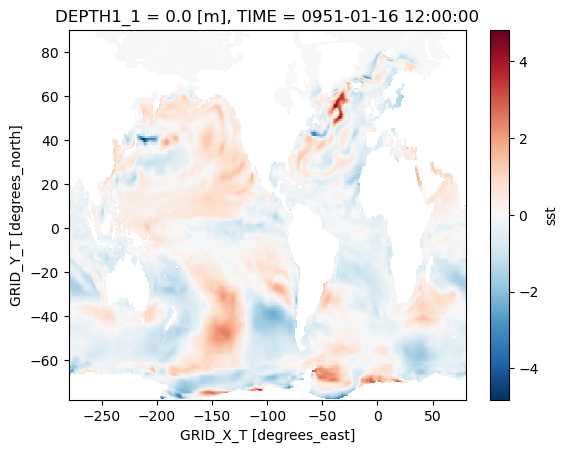

In [15]:
ctrl_anoms[0,0].plot()

In [16]:
import os

In [17]:
output_dir = "/g/data/e14/sm2435/Pacemaker/HAD_anom"

In [19]:
for i in range(int(len(ctrl_anoms.TIME)/12)):
    anoms = ctrl_anoms[:,12*i:12*i+12]
    year = ctrl_anoms[:,12*i:12*i+12].groupby('TIME.year').mean('TIME').year.values[0]
    print(year)
    #now assign coords for time
    anoms = anoms.assign_coords({"TIME":had.TIME})
    anoms_had = anoms + had
    filename = os.path.join(output_dir, f'HadISST_ctrl_anom_{year:04d}.nc')
    print(filename)

951
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0951.nc
952
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0952.nc
953
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0953.nc
954
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0954.nc
955
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0955.nc
956
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0956.nc
957
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0957.nc
958
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0958.nc
959
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0959.nc
960
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0960.nc
961
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0961.nc
962
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0962.nc
963
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0963.nc
964
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0964.nc
965
/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISS

In [21]:

#now create a loop to get each year of data, convert the time to HadISST time coord and then add anomaly to hadsst and save file
for i in range(int(len(ctrl_anoms.TIME)/12)):
    anoms = ctrl_anoms[:,12*i:12*i+12]
    year = ctrl_anoms[:,12*i:12*i+12].groupby('TIME.year').mean('TIME').year.values[0]
    print(year)
    #now assign coords for time
    anoms = anoms.assign_coords({"TIME":had.TIME})
    anoms_had = anoms + had
    filename = os.path.join(output_dir, f'HadISST_ctrl_anom_{year:04d}.nc')
    #add required metadata
    anoms_had = anoms_had.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
    anoms_had = anoms_had.to_dataset(name = 'temp')
    anoms_had =anoms_had.assign_attrs({"description": f"HadISST climatology + ACCESS-CM2 anomalies from model year {year} (HadISST Jan 1900- Dec 2019 inclusive, detrended back to 1850 using the quadratic trend T2005-T1850). For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 05/05/23"})
    
    anoms_had = anoms_had[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
    # Save the data array to the output file
    anoms_had.to_netcdf(filename, encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
